In [1]:
import numpy as np
from tqdm import tqdm

from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step
from tensoraerospace.agent.ihdp.model import IHDPAgent
from tensoraerospace.benchmark import ControlBenchmark

In [2]:
dt = 0.01  # Дискретизация
tp = generate_time_period(tn=20, dt=dt) # Временной период
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp) # Количество временных шагов
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=1000, output_rad=True), [1, -1]) # Заданный сигнал

In [7]:
import gymnasium as gym

# initial_state соответствует только выбранным состояниям
initial_state = [ [0], [0], [0]]  # Для theta, alpha, q

env = gym.make('LinearLongitudinalF16-v0', 
               number_time_steps=number_time_steps, 
               initial_state=initial_state,  # 3 элемента для 3 состояний
               reference_signal=reference_signals, use_reward=False,
               state_space= ["theta", "alpha", "q"],
               output_space=["theta", "alpha", "q" ], 
               control_space=["ele"], 
               tracking_states=["alpha"])
env.reset()

(array([[0.],
        [0.],
        [0.]], dtype=float32),
 {})

In [8]:
actor_settings = {
    "start_training": 5,
    "layers": (25, 1), 
    "activations":  ('tanh', 'tanh'), 
    "learning_rate": 2, 
    "learning_rate_exponent_limit": 10,
    "type_PE": "combined",
    "amplitude_3211": 15, 
    "pulse_length_3211": 5/dt, 
    "maximum_input": 25,
    "maximum_q_rate": 20,
    "WB_limits": 30,
    "NN_initial": 120,
    "cascade_actor": False,
    "learning_rate_cascaded":1.2
}

In [9]:
incremental_settings = {
    "number_time_steps": number_time_steps, 
    "dt": dt, 
    "input_magnitude_limits":25, 
    "input_rate_limits":60,
}

In [10]:
critic_settings = {
    "Q_weights": [8], 
    "start_training": -1, 
    "gamma": 0.99, 
    "learning_rate": 15, 
    "learning_rate_exponent_limit": 10,
    "layers": (25,1), 
    "activations": ("tanh", "linear"), 
        "WB_limits": 30,
    "NN_initial": 120,
    "indices_tracking_states": env.unwrapped.indices_tracking_states
}

In [11]:
model = IHDPAgent(actor_settings, critic_settings, incremental_settings, env.unwrapped.tracking_states, env.unwrapped.state_space, env.unwrapped.control_space, number_time_steps, env.unwrapped.indices_tracking_states)

In [12]:
xt = np.array([[0], [0], [0]])

for step in tqdm(range(number_time_steps-3)):
    ut = model.predict(xt, reference_signals, step)
    xt, reward, terminated, truncated, info = env.step(np.array(ut))

  0%|          | 0/1999 [00:00<?, ?it/s]

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
100%|██████████| 1999/1999 [00:18<00:00, 110.25it/s]


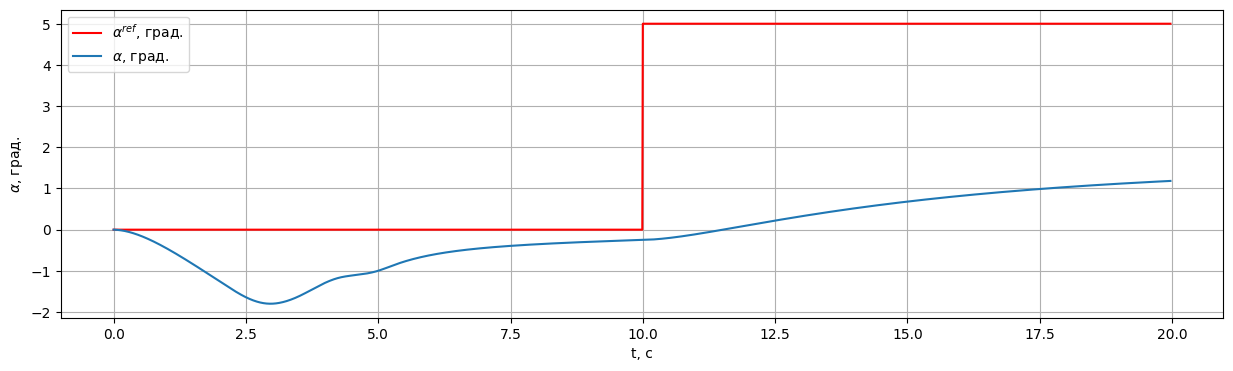

In [13]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))

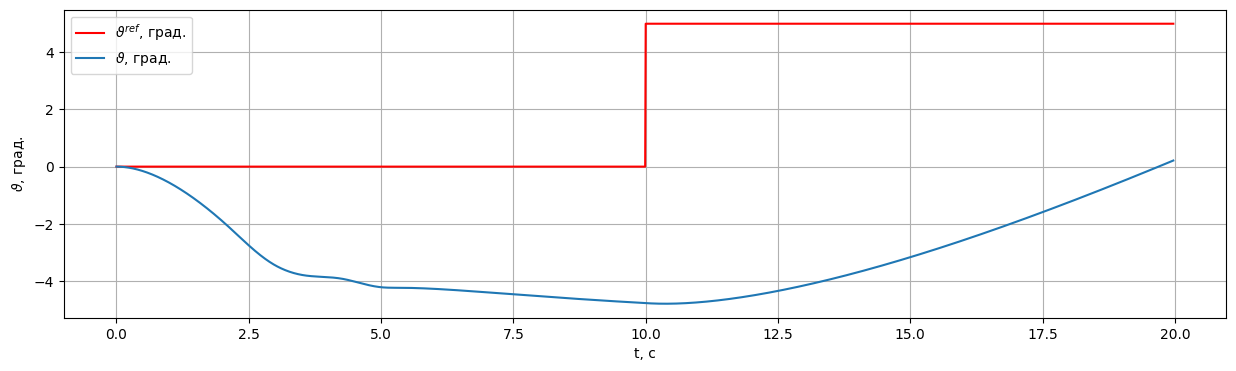

In [14]:
env.unwrapped.model.plot_transient_process('theta', tps, reference_signals[0], to_deg=True, figsize=(15,4))

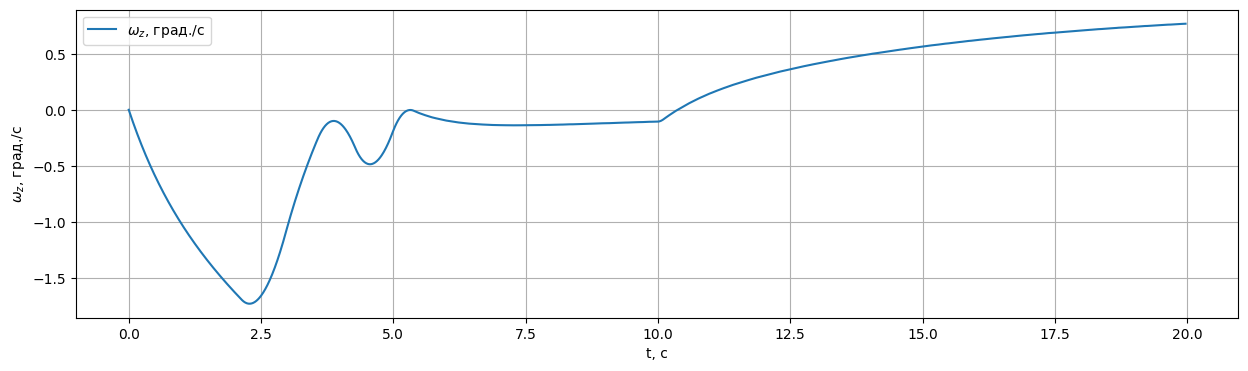

In [15]:
env.unwrapped.model.plot_state(state_name='q', time=tps, to_deg=True, figsize=(15,4))

### Оцениваем переходнный процесс

In [16]:
system_signal_orig = env.unwrapped.model.get_state('alpha', to_deg=True)[:2000]
control_signal_orig = np.rad2deg(reference_signals[0])[:2000]

In [17]:
bench = ControlBenchmark()

In [18]:
res = bench.becnchmarking_one_step(control_signal_orig, system_signal_orig, 1, dt)

In [19]:
print("Статическая ошибка: ", res['static_error'])
print("Время переходного процесса: ", res['settling_time'], "сек")
print("Степень затухания: ", res['damping_degree'])
print("Перерегулирование: ", res['overshoot'])

Статическая ошибка:  3.818391994693597
Время переходного процесса:  10.0 сек
Степень затухания:  0.0
Перерегулирование:  -76.31086410137206


In [20]:
bench.plot(control_signal_orig, system_signal_orig, 1, dt, tps, figsize=(15,5))

{'overshoot': -76.31086410137206,
 'settling_time': 10.0,
 'damping_degree': 0.0,
 'static_error': 3.818391994693597,
 'rise_time': None,
 'peak_time': 9.99,
 'maximum_deviation': 5.249583304516443,
 'iae': 4411.038037351002,
 'ise': 19654.453271299553,
 'itae': 20769.65081590833,
 'oscillation_count': 0,
 'steady_state_value': 5.0,
 'performance_index': 16184.903807703427}